## Permutation Importance with Multicollinear or Correlated Features
- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

본 예제에서는 랜덤포레스트로 위스콘신 유방암 예측 모델을 만들어 본다.   
데이터 정확도는 97%가 나올 것이다.  
PI를 계산해보면 어떤 피처도 중요하지 않다고 보여줄 것이다.   
바로 다중공선성 때문이다.  
다중공선성을 처리하는 방법은 Spearman rank-order correlations를 사용해서 클러스터를 구성하고 각 클러스터에서 하나의 피처만 추출하면된다.

In [2]:
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

모델 만들기

In [3]:
data = load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))


Accuracy on test data: 0.97


이제 feature importance와 permutation importance를 그려본다.   
pi plot은 중요한 피처가 정확도를 0.012 까지 떨어뜨리는 것을 보여준다.  
이는 이 피처가 중요하지 않다는 것을 의미하는 데 앞에서 계산한 테스트 정확도와 모순이다. 
어떤 피처는 중요해야하는데 말이다. 

In [4]:
result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
result

{'importances_mean': array([0.00140845, 0.00187793, 0.00117371, 0.00140845, 0.        ,
        0.00187793, 0.00023474, 0.00328638, 0.00070423, 0.        ,
        0.00234742, 0.        , 0.00093897, 0.00187793, 0.00117371,
        0.00140845, 0.00093897, 0.        , 0.00093897, 0.        ,
        0.00093897, 0.00258216, 0.00070423, 0.00093897, 0.00140845,
        0.        , 0.00164319, 0.00680751, 0.        , 0.        ]),
 'importances_std': array([0.00115   , 0.00093897, 0.00117371, 0.00115   , 0.        ,
        0.00093897, 0.00070423, 0.00187793, 0.00107572, 0.        ,
        0.        , 0.        , 0.00115   , 0.00093897, 0.00117371,
        0.00115   , 0.00115   , 0.        , 0.00115   , 0.        ,
        0.00115   , 0.00070423, 0.00107572, 0.00115   , 0.00115   ,
        0.        , 0.00107572, 0.00305164, 0.        , 0.        ]),
 'importances': array([[0.00234742, 0.00234742, 0.        , 0.        , 0.        ,
         0.00234742, 0.00234742, 0.00234742, 0.00234742, 

In [6]:
result['importances'].shape

(30, 10)

In [7]:
result.importances_mean.shape

(30,)

In [8]:
perm_sorted_idx = result.importances_mean.argsort()
perm_sorted_idx

array([29, 25,  4, 19,  9, 11, 17, 28,  6, 22,  8, 23, 20, 18, 12, 16, 14,
        2,  3, 24, 15,  0, 26, 13,  5,  1, 10, 21,  7, 27])

In [9]:
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

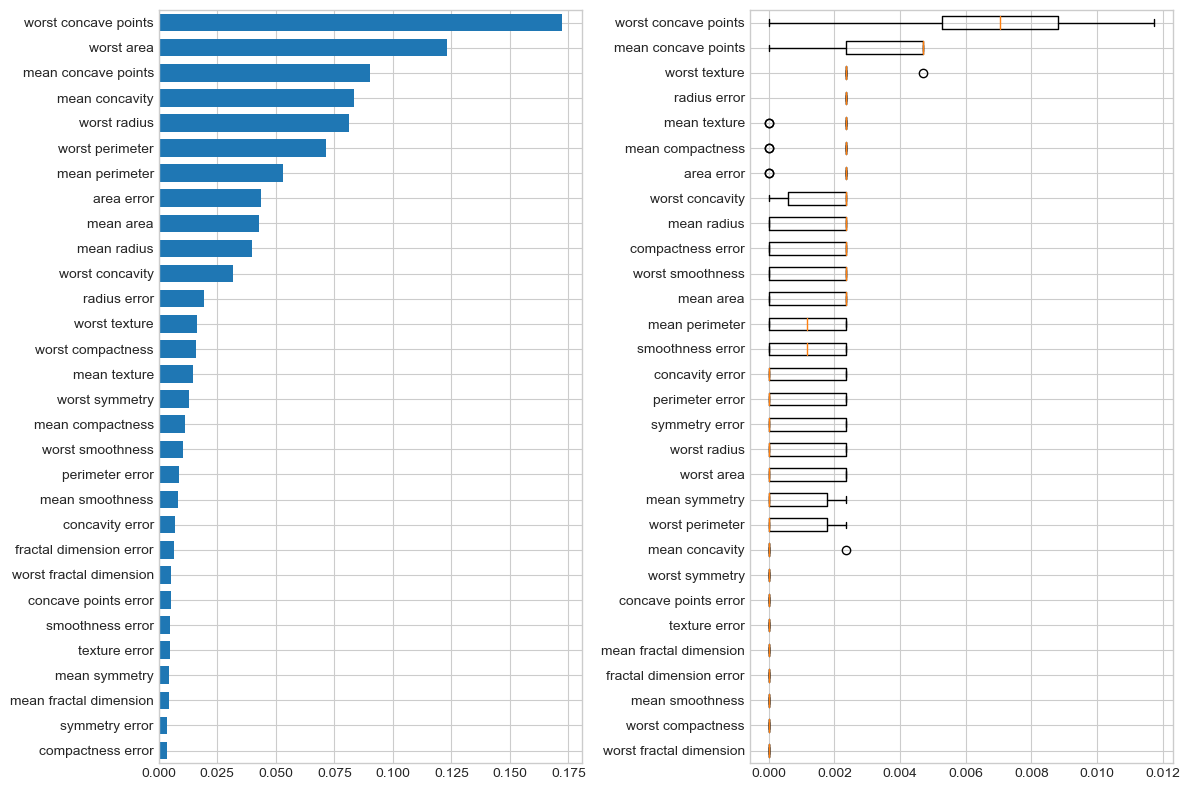

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height = 0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))

ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=data.feature_names[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

### Handling Multicollinear Features

피처들이 공선성을 가지는 경우, 한 피처를 permutating해도 모델 성능에 영향을 거의 안미친다.  
외냐하면 상관성이 높은 다른 피처가 정보를 제공하기 때문이다.   
multicollinear feature를 다루는 한 방법은 Spearman rank-order correlation을 통한 hierachical clustering을 사용하는 것이다.  
스레스홀드를 정하고 각 클러스터에서 하나의 피처만 사용하는 것이다.

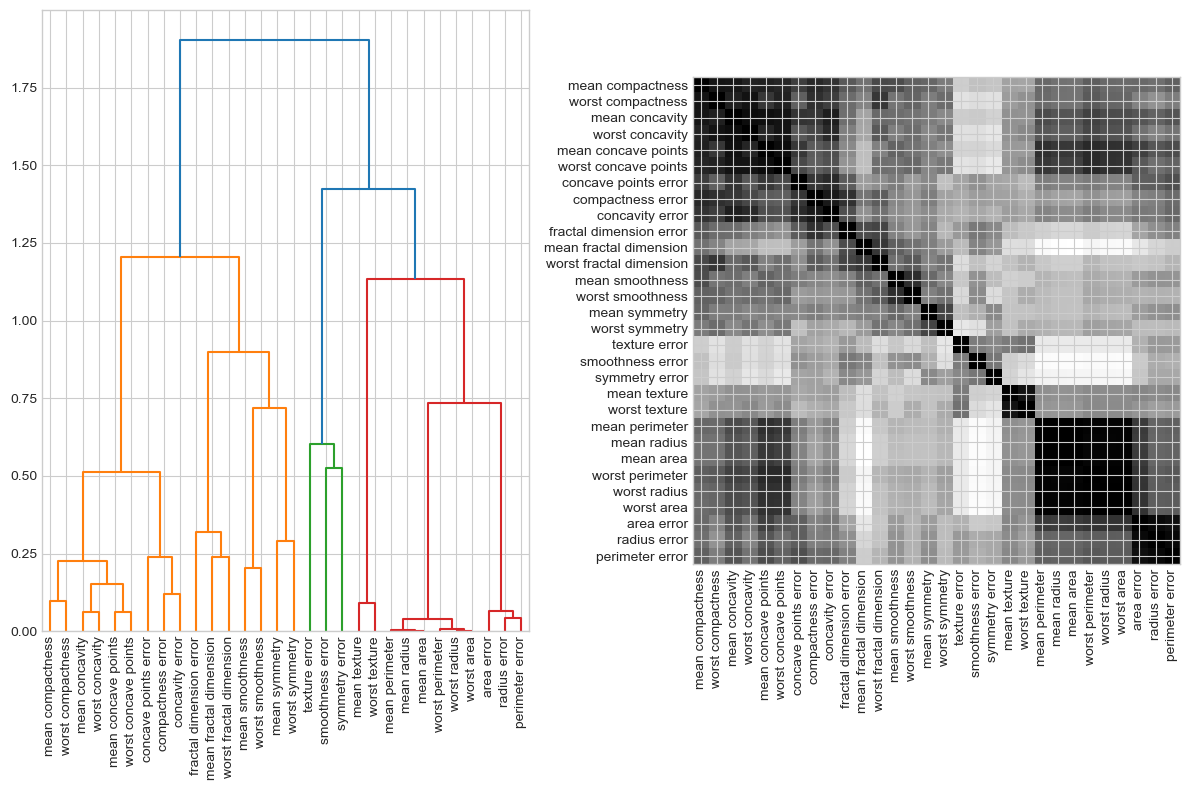

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))
corr = spearmanr(X).correlation

# corr 매트릭스가 symmetric한지 확인
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1) # 대각성분 1로 대체

# corr mat를 distance mat로 변환한다.
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

이제 덴드로그램을 육안으로 검사하여 임계값을 수동으로 선택하여, 클러스터를 그룹화한다.   
각 클러스터에서 유지할 피처를 선택하고, 랜덤포레스트를 학습한다.

In [12]:
dist_linkage

array([[0.00000000e+00, 3.00000000e+00, 3.97972193e-04, 2.00000000e+00],
       [2.00000000e+01, 2.30000000e+01, 1.10944691e-03, 2.00000000e+00],
       [2.00000000e+00, 3.00000000e+01, 2.98308588e-03, 3.00000000e+00],
       [2.20000000e+01, 3.10000000e+01, 8.09452461e-03, 3.00000000e+00],
       [3.20000000e+01, 3.30000000e+01, 3.81816149e-02, 6.00000000e+00],
       [1.00000000e+01, 1.20000000e+01, 4.22715357e-02, 2.00000000e+00],
       [6.00000000e+00, 2.60000000e+01, 6.14565180e-02, 2.00000000e+00],
       [7.00000000e+00, 2.70000000e+01, 6.29252825e-02, 2.00000000e+00],
       [1.30000000e+01, 3.50000000e+01, 6.66652787e-02, 3.00000000e+00],
       [1.00000000e+00, 2.10000000e+01, 9.07817128e-02, 2.00000000e+00],
       [5.00000000e+00, 2.50000000e+01, 9.89713287e-02, 2.00000000e+00],
       [1.50000000e+01, 1.60000000e+01, 1.19034966e-01, 2.00000000e+00],
       [3.60000000e+01, 3.70000000e+01, 1.51582869e-01, 4.00000000e+00],
       [4.00000000e+00, 2.40000000e+01, 2.03914715e

In [13]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance") # 여기서는 1로 설정
cluster_id_to_feature_ids = defaultdict(list)

In [14]:
cluster_id_to_feature_ids

defaultdict(list, {})

In [15]:
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

In [16]:
selected_features

[0, 1, 4, 5, 11]

In [17]:
X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Accuracy on test data with features removed: {:.2f}".format(
        clf_sel.score(X_test_sel, y_test)
    )
)

Accuracy on test data with features removed: 0.97


- 피처를 줄였음에도 성능저하가 거의 없다.